# Import Libraries / Data

In [1]:
import pandas as pd 
import numpy as np

#process sentences and tokens
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.text import Text

#find frequent words
from nltk.probability import FreqDist

#draw network graphs, wordclouds, dendrograms
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import json #open saved tokens
from textblob import TextBlob #sentiment analysis

In [2]:
#import data
with open('data.json') as json_file:
    data = json.load(json_file)

# Functions 

In [11]:
#a function to find frequently co-occour n words of a specific word in a token set 
def freq(tokens,word,num):            
    #find concordance sentences
    textList = Text(tokens)
    a = textList.concordance_list(word,width=100,lines=10000)
    tokenizer = RegexpTokenizer('\w+')

    #store sentencesin the list(cc_list, cc_flat)
    cc_list = []
    cc_flat = []
    for i in range(len(a)):    
        sentence = a[i][4]+" "+a[i][1]+" "+a[i][5]
        to=tokenizer.tokenize(sentence)
        to_save=to[1:len(to)-1]
        cc_list.append(to_save) #keep sentences
        cc_flat.extend(to_save) #only left words

    #find top (num) frqeunt words 
    freqdist = FreqDist(cc_flat)
    df_fdist = pd.DataFrame.from_dict(freqdist, orient='index')
    frequent_words=df_fdist.nlargest(num, [0], keep='first')
    frequent_words=frequent_words[frequent_words[0]>2]

    #store frqeunt words in a list(freq_list)
    freq_list = frequent_words.index.to_list()
    
    
    #create co-occurrence matrix
    global df
    df=pd.DataFrame(index=freq_list, columns=freq_list).fillna(0)    
    for i in range(len(freq_list)-1): #first word
        for j in range(i+1,len(freq_list)): #second word
            count=0 #count co-occurrence of 2 words
            for k in cc_list: #concor list
                if freq_list[i] in k:
                    if freq_list[j] in k:
                        count=count+1
            df.at[freq_list[i],freq_list[j]] = df.at[freq_list[j],freq_list[i]] =count
            
    return True

In [4]:
#a function to draw co-occurrence graph
def draw_plot(co_matrix,year): 
    nodes= co_matrix.index.tolist()
    
    #node size
    global node_sizes
    node_sizes={}
    for i in nodes:
        w = 0
        for j in nodes:
            w = w + co_matrix.at[i,j]
        node_sizes.update({i:w})  


    #set edges
    edge_list = [] 
    for i in nodes:
        for j in nodes:
            if co_matrix.at[i,j] != 0 :
                edge_list.append((i,j,co_matrix.at[i,j]))

    #draw plot            

    plt.subplots(figsize=(10,10))  #plot size
    ax = plt.gca() #plot title
    ax.set_title(year)
    
    G = nx.Graph()
    
    #add nodes with sizes
    for i in nodes:
        G.add_node(i, size = node_sizes.get(i))
        
    #add edges with weihgts    
    G.add_weighted_edges_from(edge_list)   
    edges = G.edges()
    weights = [G[u][v]['weight']/50 for u,v in edges]
    
    #set positions of nodes
    pos = nx.spring_layout(G, k=0.42, iterations=17)
    
    #draw graph
    nx.draw(G, pos, with_labels=True, font_size = 10, font_weight = 'bold',
            node_size=[v * 0.5 for v in node_sizes.values()], node_color="skyblue",edge_color='lightgrey',width=weights)
    plt.show()   

    #to store graph information - nodes, edges    
    #get edge list from a graph
    edges_list=list(G.edges)
    
    #create a dataframe to store nodes and weights
    global df_info
    df_info=pd.DataFrame(columns=["node1","node2","weight"])

    for i in range(len(edges_list)):
        if edges_list[i][0] < edges_list[i][1]:
            df_info.at[i,"node1"]=edges_list[i][0]
            df_info.at[i,"node2"]=edges_list[i][1]        
        else:
            df_info.at[i,"node1"]=edges_list[i][1]
            df_info.at[i,"node2"]=edges_list[i][0]        
        df_info.at[i,"weight"]=weights[i]

    return True

In [5]:
#to find overlapped words between years
def common(lst1, lst2):
    return set(lst1).intersection(lst2)

#to get location of a specific value in a dataframe
  #reference: https://www.geeksforgeeks.org/find-location-of-an-element-in-pandas-dataframe-in-python/
def getIndexes(df, value):   
    position = []
    result = df.isin([value]) #Whether each element in the DataFrame is contained in value
    serises = result.any()
    col_list= list(serises[serises == True].index)  
    for col in col_list:
        rows = list(result[col][result[col] == True].index) 
        for row in rows:
            position.append((row, col)) #find location and store in the position list
    return position[0] #return only the first one

#to plot dendrogram and find the most/least similiar graphs
def plot_dendrogram(df,title):
    #ref1: https://www.learndatasci.com/glossary/hierarchical-clustering/
    #ref2: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    labels=df.index.to_list()
    dists = squareform(df) 
    linkage_matrix = linkage(dists, "ward")  #The Ward approach analyzes the variance of the clusters rather than measuring distances directly, minimizing the variance between clusters.
    fig = plt.figure(figsize=(20, 10))
    dendrogram(linkage_matrix, labels=labels)
    plt.title("Dendrogram: "+title)
    plt.show()
    
    all_values=[]
    for i in year:
        all_values.extend(list(df[i]))
    all_values_none_zero=[x for x in all_values if x>0]

    print("The most similar years",getIndexes(df,min(all_values_none_zero)))
    print("The least similar years",getIndexes(df,max(all_values)))

In [6]:
#to find frequency of bigrams in token set
def freq_bigram(tokens,word1,word2):
    bgs=nltk.bigrams(tokens)
    fdist_bi = nltk.FreqDist(bgs)
    global counts
    counts=fdist_bi[(word1, word2)]
    return counts

#to plot frequency of bigrams in token set
def freq_plot(dict,word):
    plt.figure(figsize=(15,8))
    xAxis=list(dict.keys())
    yAxis=list(dict.values())
    plt.plot(xAxis,yAxis,color='blue', marker='o')
    plt.title('Frequency :'+word,fontsize=14)
    plt.xlabel('year')
    plt.ylabel('frequency')
    plt.grid(True)
    plt.show()

# Frequency of 'Climate change'

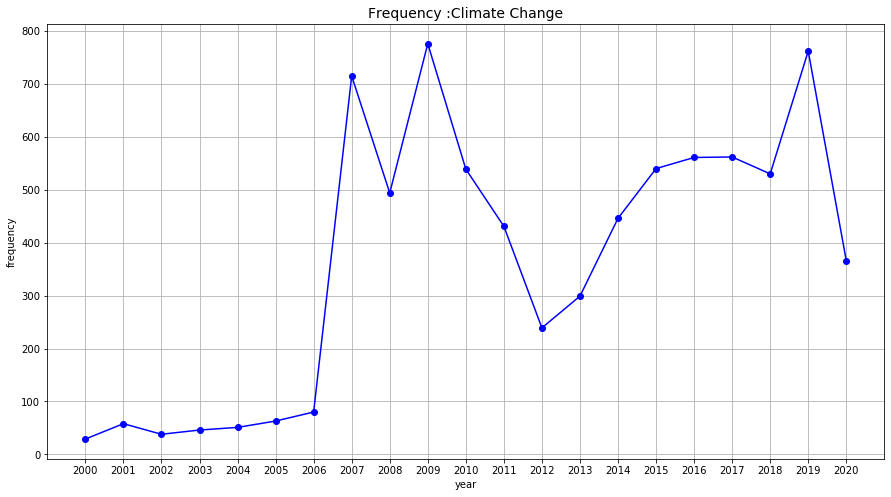

In [8]:
#1)Create frequency dictionary
freq_climate={}
for i in data:
    freq_bigram(data[i],'climate','change')
    freq_climate.update({i:counts})


#2)Draw a frequency plot
freq_plot(freq_climate,'Climate Change')

# Jaccard simiarlity (2000-2020, Climate)

In [9]:
#1) craete year list and dataframe for storing jaccard similarities
year=list(freq_climate.keys())
jac_df=pd.DataFrame(index=year,columns=year).fillna(0.0)

C:\Users\sooje\AppData\Roaming\Python\Python38\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


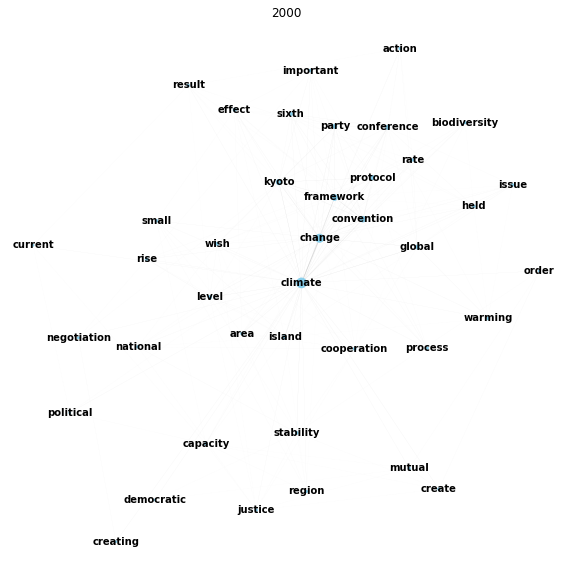

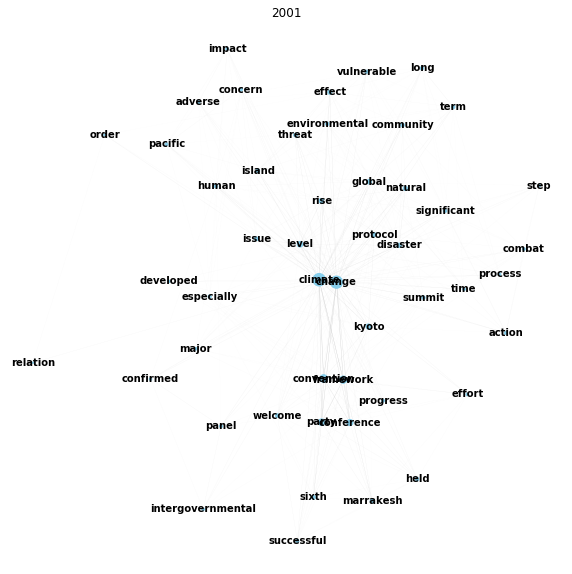

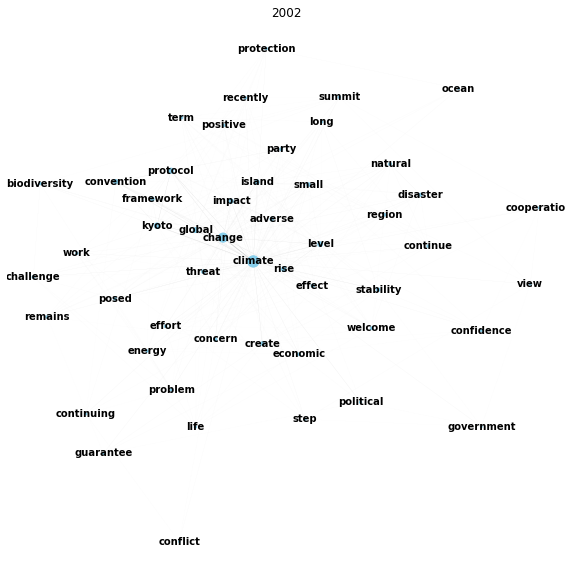

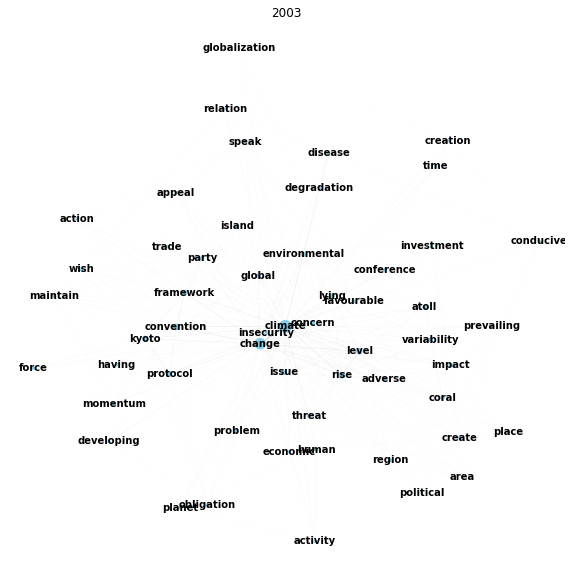

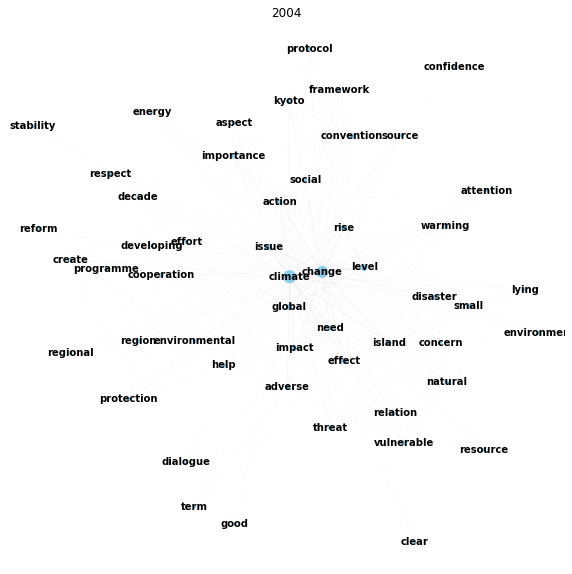

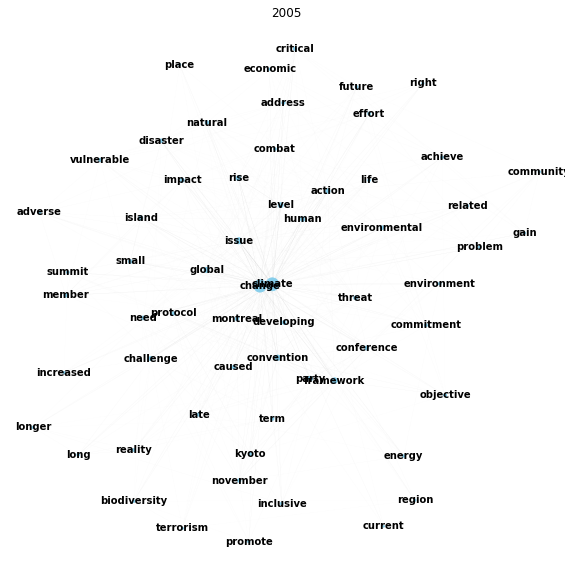

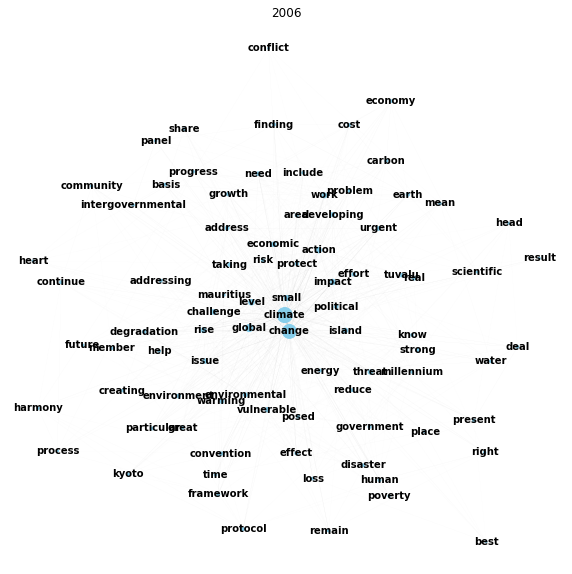

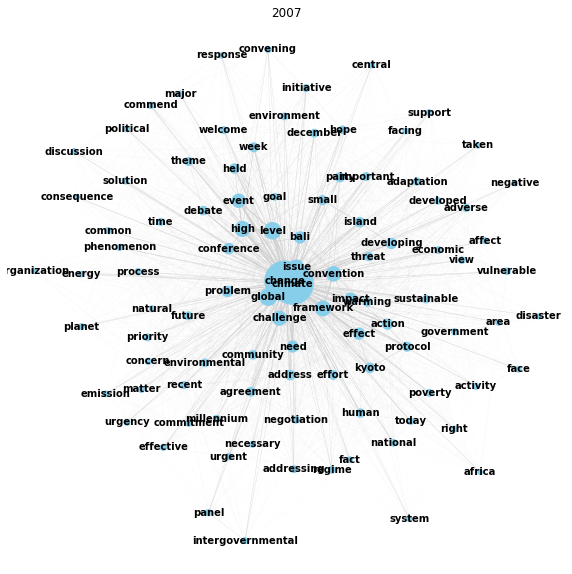

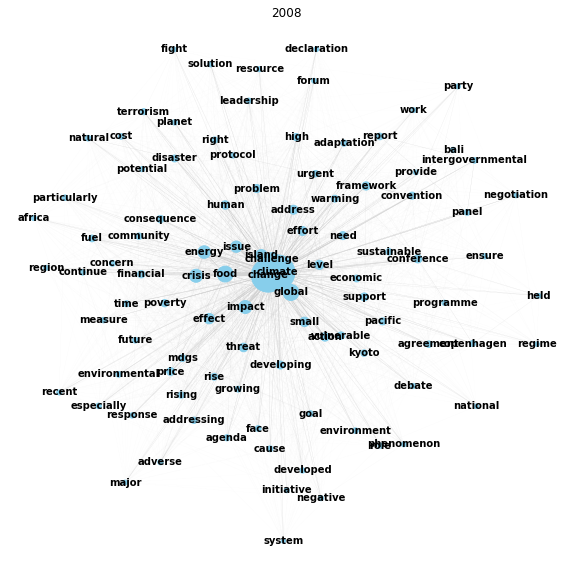

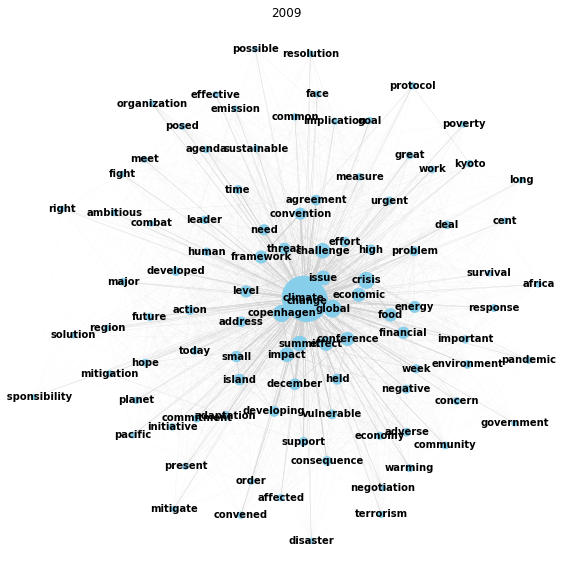

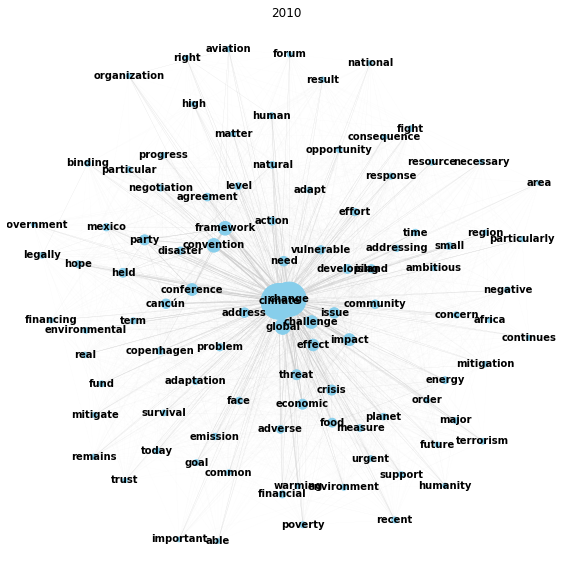

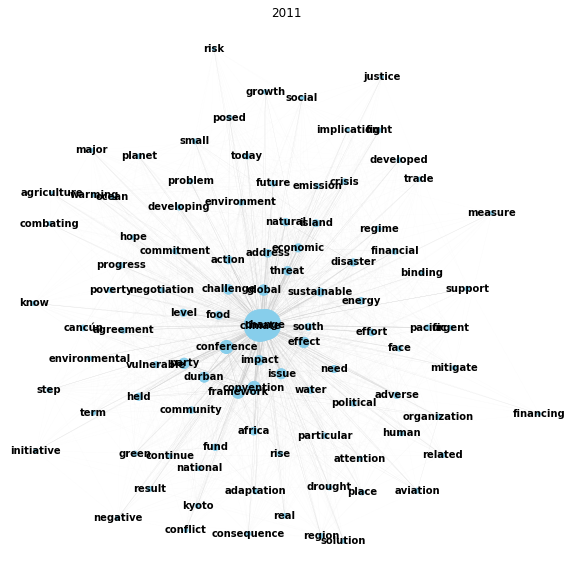

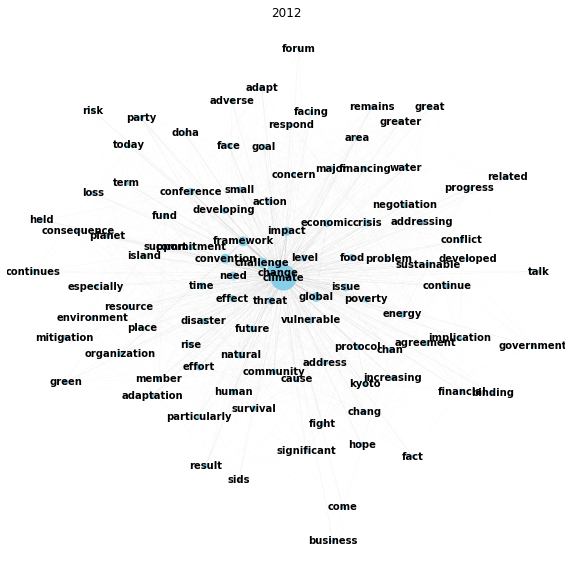

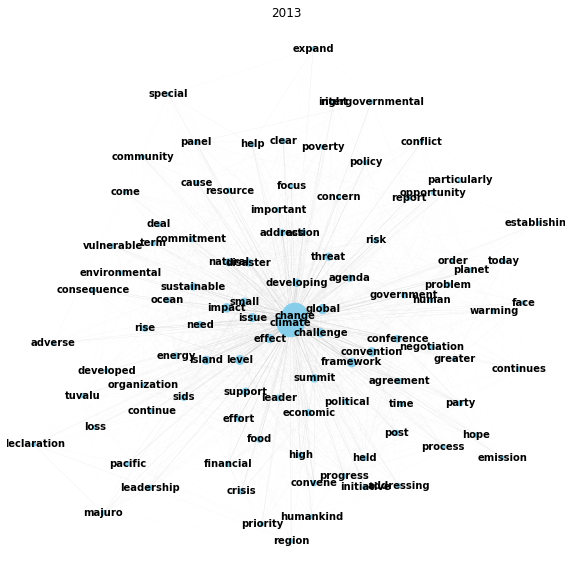

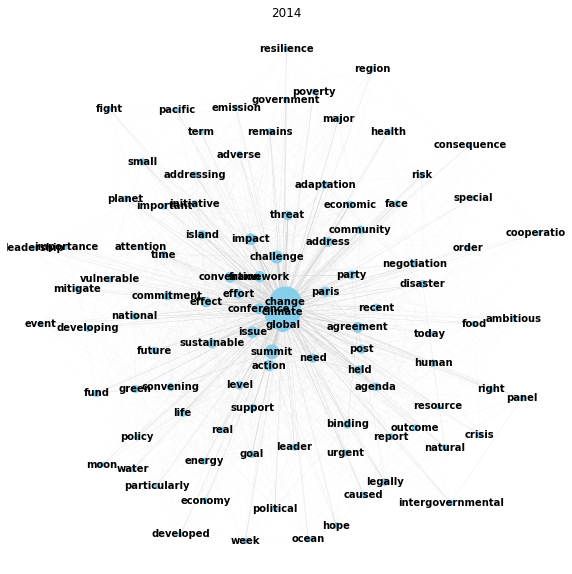

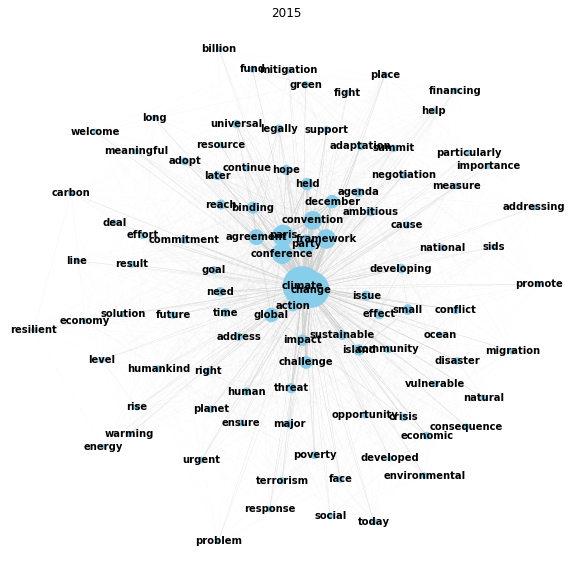

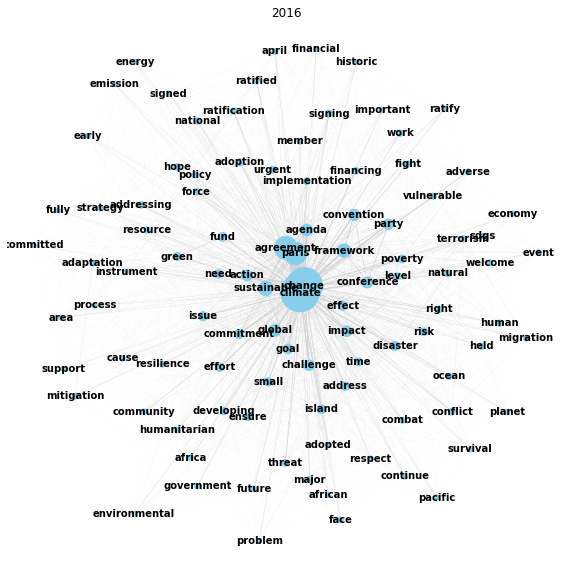

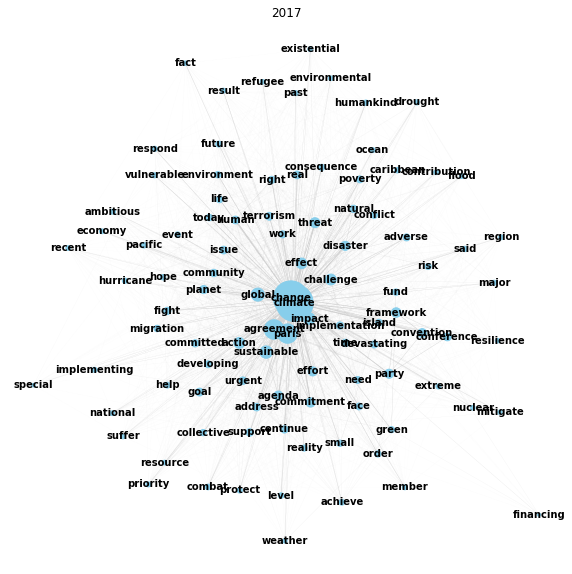

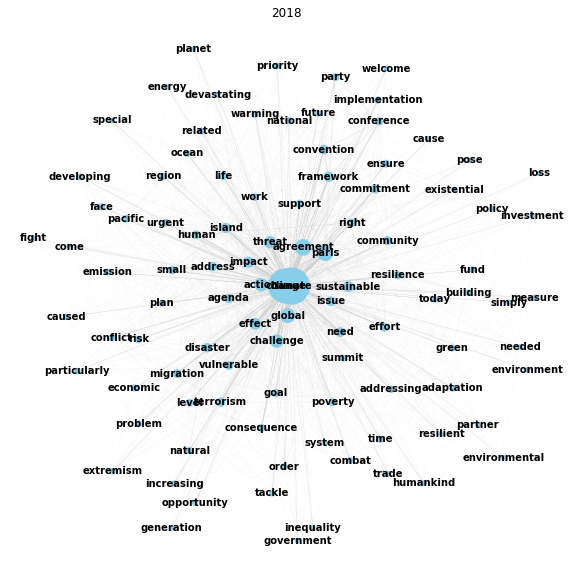

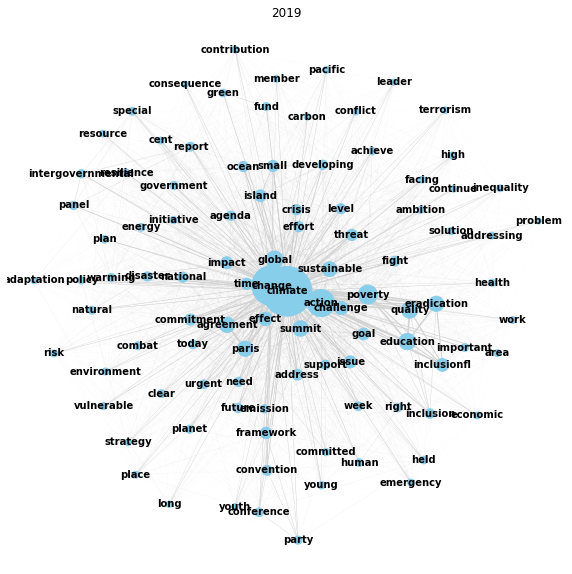

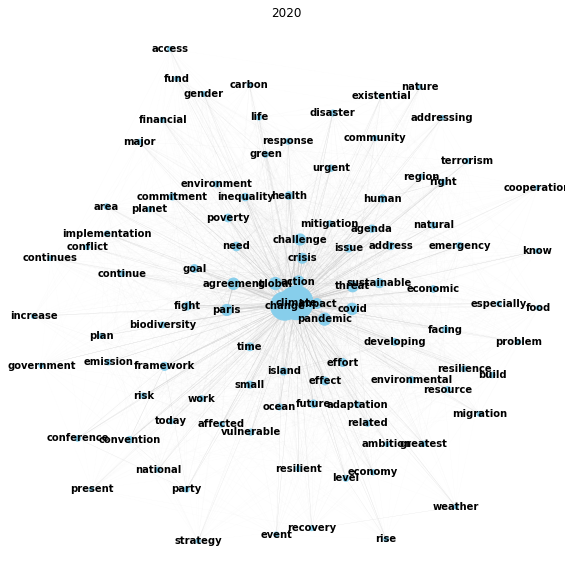

In [12]:
#2) generate a network graph and its information of each year 

info_dict={}
for i in year:
    #token set of each year
    data[i] 
    
    #get co-occurence list with 'climate'
    freq(data[i],'climate',100)

    #draw nework
    draw_plot(df,i)
    
    #get network information and updata as dictionary
    info_dict.update({i:df_info.to_dict('dict')})

In [13]:
#3) calculate similarities between every 2 networks

for i in year:
    for j in year:
        if i <= j:
            
            #create outer-join dataframe
            a=pd.DataFrame.from_dict(info_dict[i])
            b=pd.DataFrame.from_dict(info_dict[j])
            k=pd.merge(a,b,on=["node1","node2"],how="outer")
            k=k.fillna(0)
            
            #find the number of common edges
            common_edges=k[(k["weight_x"]>0) & (k["weight_y"]>0)]

            
            #find the number of common nodes
            a_node=list(set(list(a['node1'])+list(a['node2'])))
            b_node=list(set(list(b['node1'])+list(b['node2'])))
            common_nodes=common(a_node, b_node)
            
            #calculate jaccard distance and jaccard similarity
            #jaccard distance= (1 - common nodes) / (all nodes of a + all nodes of b -common nodes)
            jac_dist=1-(len(common_nodes)/(len(a_node)+len(b_node)-len(common_nodes)))
            
            #jaccard similarity = (jaccard distance) / (1 + common edges)
            jac_sim=jac_dist/(1+len(common_edges))
            
            #update jaccard similarity dataframe
            jac_df.at[j,i]=jac_sim
            jac_df.at[i,j]=jac_sim
    
#print dataFrame
jac_df

2000      2001      2002      2003      2004      2005      2006  \
2000  0.000000  0.011209  0.013078  0.012874  0.012538  0.014776  0.014234   
2001  0.011209  0.000000  0.007158  0.009338  0.006683  0.006272  0.009065   
2002  0.013078  0.007158  0.000000  0.011544  0.006667  0.007363  0.008777   
2003  0.012874  0.009338  0.011544  0.000000  0.009712  0.009203  0.011170   
2004  0.012538  0.006683  0.006667  0.009712  0.000000  0.006071  0.007110   
2005  0.014776  0.006272  0.007363  0.009203  0.006071  0.000000  0.006073   
2006  0.014234  0.009065  0.008777  0.011170  0.007110  0.006073  0.000000   
2007  0.009027  0.004616  0.007294  0.008118  0.005521  0.003990  0.003479   
2008  0.010980  0.004544  0.006450  0.008049  0.004959  0.004009  0.003524   
2009  0.011737  0.005304  0.007160  0.010707  0.006105  0.004032  0.003716   
2010  0.011622  0.005879  0.009195  0.010589  0.005491  0.004571  0.004011   
2011  0.011159  0.005266  0.006466  0.009718  0.005061  0.003972  0.003426   
2012  0.013228  0.005300  0.007680  0.010216  0.006561  0.004430  0.004177   
2013  0.011791  0.004950  0.006696  0.010470  0.005386  0.004571  0.003741   
2014  0.012478  0.005760  0.008375  0.014273  0.006173  0.004571  0.005198   
2015  0.012582  0.006319  0.008233  0.012438  0.006222  0.004103  0.004400   
2016  0.013749  0.006067  0.009756  0.013661  0.007454  0.004606  0.004482   
2017  0.018735  0.007560  0.010110  0.014925  0.006865  0.004176  0.004563   
2018  0.016573  0.006953  0.008484  0.012124  0.007593  0.003718  0.004399   
2019  0.013115  0.006831  0.008781  0.014273  0.006660  0.003964  0.003623   
2020  0.015327  0.008678  0.008561  0.012124  0.007301  0.004469  0.003951   

          2007      2008      2009  ...      2011      2012      2013  \
2000  0.009027  0.010980  0.011737  ...  0.011159  0.013228  0.011791   
2001  0.004616  0.004544  0.005304  ...  0.005266  0.005300  0.004950   
2002  0.007294  0.006450  0.007160  ...  0.006466  0.007680  0.006696   
2003  0.008118  0.008049  0.010707  ...  0.009718  0.010216  0.010470   
2004  0.005521  0.004959  0.006105  ...  0.005061  0.006561  0.005386   
2005  0.003990  0.004009  0.004032  ...  0.003972  0.004430  0.004571   
2006  0.003479  0.003524  0.003716  ...  0.003426  0.004177  0.003741   
2007  0.000000  0.000759  0.000728  ...  0.001214  0.001538  0.001301   
2008  0.000759  0.000000  0.000739  ...  0.001108  0.001287  0.001182   
2009  0.000728  0.000739  0.000000  ...  0.001000  0.001328  0.001159   
2010  0.000835  0.000835  0.000629  ...  0.000860  0.001054  0.001320   
2011  0.001214  0.001108  0.001000  ...  0.000000  0.001207  0.001364   
2012  0.001538  0.001287  0.001328  ...  0.001207  0.000000  0.001330   
2013  0.001301  0.001182  0.001159  ...  0.001364  0.001330  0.000000   
2014  0.001085  0.001164  0.000878  ...  0.001092  0.001439  0.001007   
2015  0.001260  0.001071  0.000988  ...  0.001132  0.001250  0.001293   
2016  0.001272  0.001367  0.001235  ...  0.001503  0.001529  0.001592   
2017  0.001680  0.001596  0.001445  ...  0.001520  0.001992  0.001838   
2018  0.001440  0.001237  0.001236  ...  0.001480  0.001810  0.001349   
2019  0.001037  0.001043  0.000885  ...  0.001373  0.001525  0.001167   
2020  0.001614  0.001417  0.001329  ...  0.001596  0.001621  0.002055   

          2014      2015      2016      2017      2018      2019      2020  
2000  0.012478  0.012582  0.013749  0.018735  0.016573  0.013115  0.015327  
2001  0.005760  0.006319  0.006067  0.007560  0.006953  0.006831  0.008678  
2002  0.008375  0.008233  0.009756  0.010110  0.008484  0.008781  0.008561  
2003  0.014273  0.012438  0.013661  0.014925  0.012124  0.014273  0.012124  
2004  0.006173  0.006222  0.007454  0.006865  0.007593  0.006660  0.007301  
2005  0.004571  0.004103  0.004606  0.004176  0.003718  0.003964  0.004469  
2006  0.005198  0.004400  0.004482  0.004563  0.004399  0.003623  0.003951  
2007  0.001085  0.001260  0.001272  0.001680  0.001440  0.001037  0.00

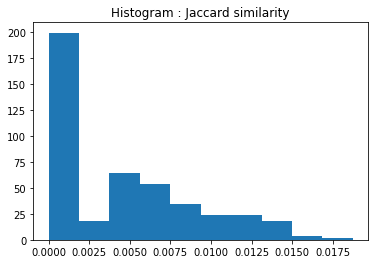

In [14]:
#4) Statistics of jaccard simiarlity data frame

#4-1)histogram of jaccard similarity
jac_df_list=[]
year=jac_df.index.to_list()
for i in year:
    jac_df_list.extend(list(jac_df[i]))
fig= plt.hist(jac_df_list, bins=10) 
plt.title("Histogram : Jaccard similarity")
plt.show()

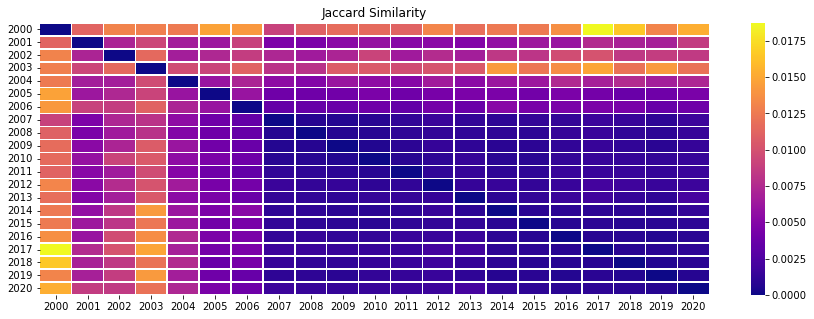

In [15]:
#4-2) Plot heat map of jaccard similarity - 0.000=similar, 0.010 = not similar
plt.subplots(figsize=(15,5)) 
ax = sns.heatmap(jac_df,linewidth = 0.5, cmap = 'plasma')
plt.title( "Jaccard Similarity" )
plt.show()

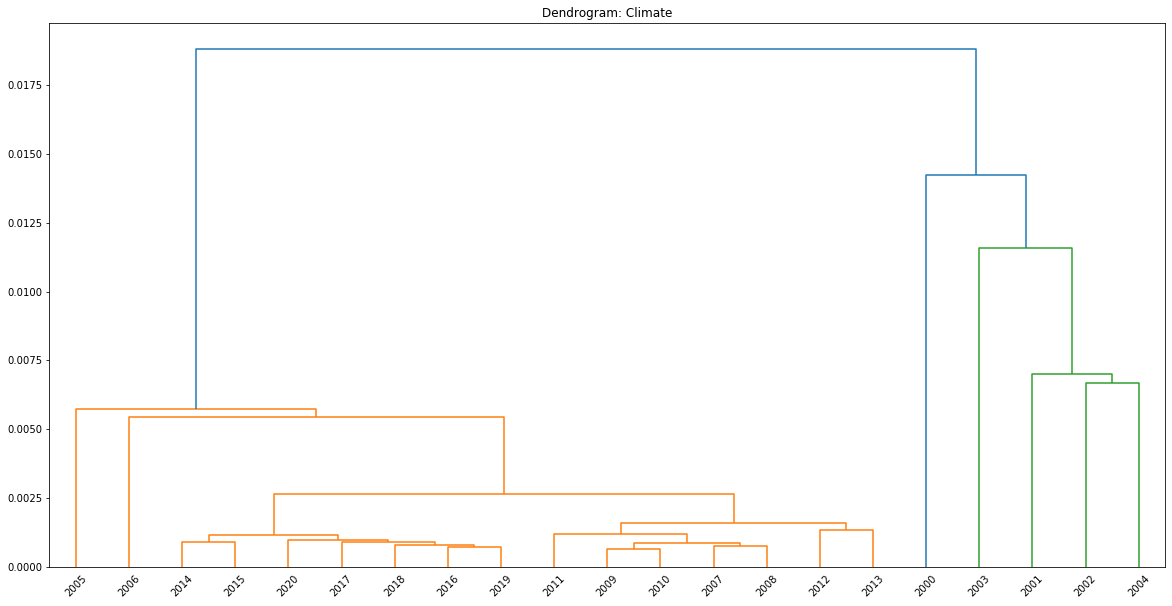

The most similar years ('2010', '2009')
The least similar years ('2017', '2000')


In [16]:
#4-3) draw dendrogram of climate 
plot_dendrogram(jac_df,"Climate")

# Compare 2 graphs - the least similar graphs (2000,2017)

In [17]:
#1) initial setting
year1='2000'
year2='2017'
word='climate'

In [18]:
#2) get frequently co-occur words with "climate"
freq(data[year1],word,100)
before_df=df

freq(data[year2],word,100)
after_df=df

C:\Users\sooje\AppData\Roaming\Python\Python38\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


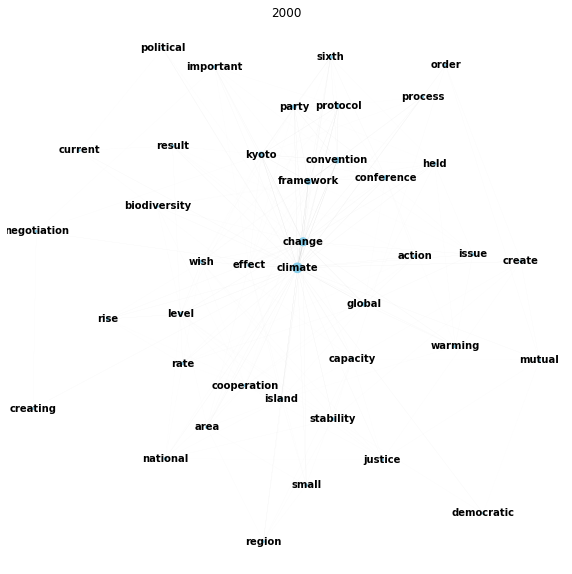

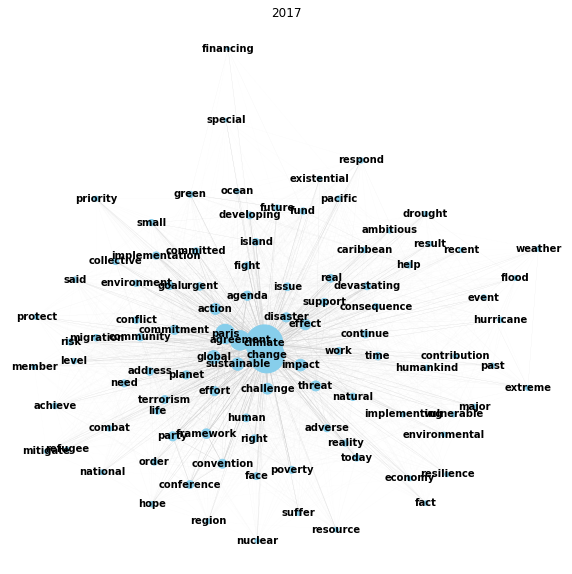

In [19]:
#3) Draw concordance network graphs
draw_plot(before_df,year1)
node_size_before=node_sizes
before_info=df_info


draw_plot(after_df,year2)
node_size_after=node_sizes
after_info=df_info

In [20]:
#4) Similarity info
print("Total edges in the Graph",year1,":",len(before_info))
print("Total edges in the Graph",year2,":",len(after_info))

#total edges
k=pd.merge(before_info,after_info,on=["node1","node2"],how="outer")
k=k.fillna(0)
common_edges=k[(k["weight_x"]>0) & (k["weight_y"]>0)]
print("The number of common edges:",len(common_edges))

before_node=before_df.index.tolist()
after_node=after_df.index.tolist()
print("Total nodes in the Graph ",year1,":",len(before_node))
print("Total nodes in the Graph ",year2,":",len(after_node))
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

common_nodes=common(before_node, after_node)
print("The number of common nodes :", len(common_nodes))


before_set=list(set(before_node)-set(common_nodes))
after_set=list(set(after_node)-set(common_nodes))

common_edges=k[(k["weight_x"]>0) & (k["weight_y"]>0)]
before_edges=k[(k["weight_x"]>0) & (k["weight_y"]==0)]
after_edges=k[(k["weight_x"]==0) & (k["weight_y"]>0)]



#Jaccard similarity : [JaccardDist(nodes) / (1 + edgeCount)]
#edgeCount = the number of common edges
#JaccardDist(node) = intersection of nodes/union of nodes
jac_dist=1-(len(common_nodes)/(len(before_node)+len(after_node)-len(common_nodes)))
print("Jaccard distance:",jac_dist)
jac_sim=jac_dist/(1+len(common_edges))
print("Jaccard similarity(=jac_dist/(1+len(common_edges)):",jac_sim)
print("cross check:",jac_df.at['2000','2017'])

Total edges in the Graph 2000 : 201
Total edges in the Graph 2017 : 1774
The number of common edges: 45
Total nodes in the Graph  2000 : 40
Total nodes in the Graph  2017 : 100
The number of common nodes : 17
Jaccard distance: 0.8617886178861789
Jaccard similarity(=jac_dist/(1+len(common_edges)): 0.018734535171438672
cross check: 0.018734535171438672


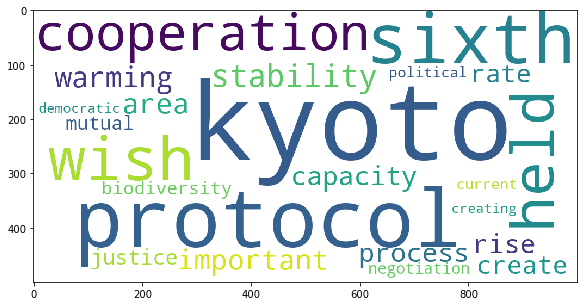

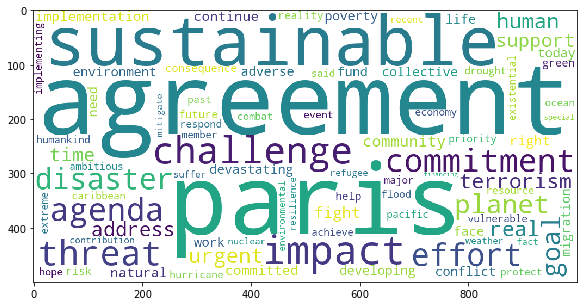

In [21]:
#5) generate word cloud of unique words of each year

before_only_freq={}
for i in before_set:
    before_only_freq.update({i:node_size_before[i]})
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(before_only_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)

after_only_freq={}
for i in after_set:
    after_only_freq.update({i:node_size_after[i]})
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(after_only_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)

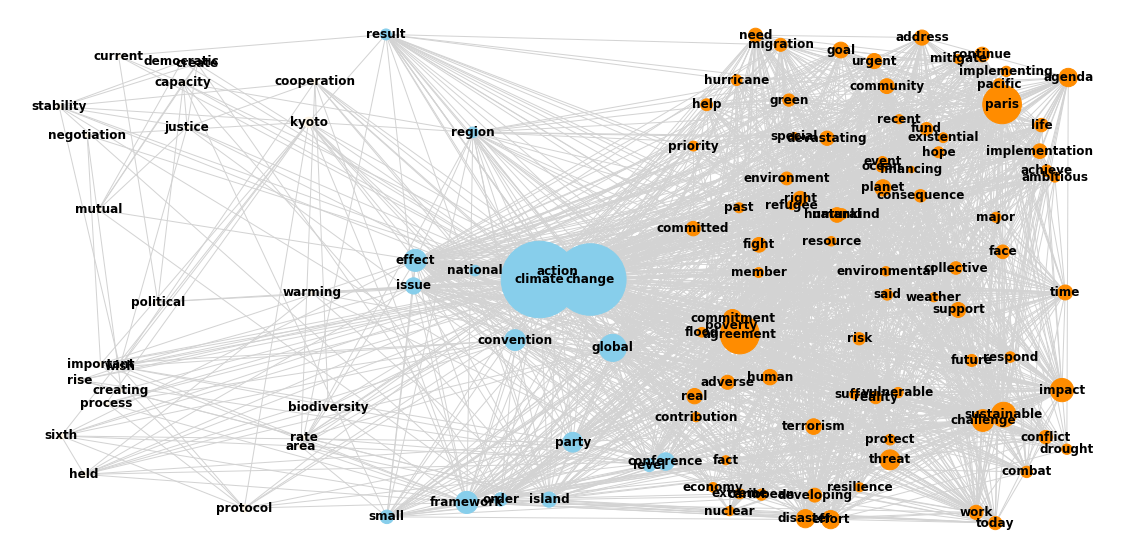

In [22]:
#6)draw joined graph
import random
plt.subplots(figsize=(20,10)) 
G=nx.from_pandas_edgelist(k, 'node1', 'node2')
pos = nx.spring_layout(G, k=1, iterations=5)
node_sizes={}
color_map = []
shape=[]
for node in G:
    w=0
    if node == 'climate':
        color_map.append('skyblue')  
        pos[node][0]=-0.05
        pos[node][1]=0
        w=node_size_before[node]+node_size_after[node]
    elif node == 'change':
        color_map.append('skyblue')  
        pos[node][0]=0.05
        pos[node][1]=0
        w=node_size_before[node]+node_size_after[node]
    elif node in before_set:
        color_map.append('oldlace')
        pos[node][0]=random.uniform(-1, -0.45)
        w=node_size_before[node]
    elif node in after_set: 
        color_map.append('darkorange')
        pos[node][0]=random.uniform(0.25, 1)
        w=node_size_after[node]
    else: 
        color_map.append('skyblue')  
        pos[node][0]=random.uniform(-0.4, 0.2)
        w=node_size_before[node]+node_size_after[node]
    node_sizes.update({node:w})

#pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos, node_color=color_map,node_size=[min(9000,v*2) for v in node_sizes.values()],font_size=12, edge_color='lightgrey',font_weight = 'bold', with_labels=True)
plt.show()



In [23]:
#7)Sentiment analysis comparison
before_set
text=""
for i in before_set:
    text=text+i+" "
#print(text)
blob = TextBlob(text)
print("Sentiment analysis of",year1,":",blob.sentiment)

after_set
text=""
for i in after_set:
    text=text+i+" "
#print(text)
blob = TextBlob(text)
print("Sentiment analysis of",year2,":",blob.sentiment)

Sentiment analysis of 2000 : Sentiment(polarity=0.13333333333333333, subjectivity=0.5)
Sentiment analysis of 2017 : Sentiment(polarity=-0.05854591836734694, subjectivity=0.4701530612244898)
